## Serie de tiempo Motor a Gasolina GX160H2 QBT

Maribel Medina Arboleda \
Manuel Alberto Peñafiel Mendoza \
Carlos Alberto Lenguerque Moreno \

El conjunto de datos con el que se desarrolló el proyecto es una base de datos otorgada por la empresa Energía y Potencia SAS, empresa comercializadora de productos para el agro a nivel nacional

Histórico de ventas de cada producto desde el año 2014
Variable respuesta: Ventas en unidades
Variables explicativas: Año y mes de ventas, Producto, Stock 

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [61]:
pip install skforecast

In [62]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from joblib import dump, load

In [63]:
data = pd.read_csv('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/GX160H2-QTB.csv', index_col=0, parse_dates=True)
data.head()

,Ventas
Meses,
2014-01-01,110
2014-02-01,88
2014-03-01,31
2014-04-01,82
2014-05-01,59


In [64]:
data.describe()

,Ventas
count,93.000000
mean,45.032258
std,34.443543
min,1.000000
25%,21.000000
50%,36.000000
75%,57.000000
max,183.000000


In [65]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# --- Donde parse_dates indica qué columna de los datos se selecciona como información de fecha y hora,
# --- index_col le dice a los pandas qué columna usar como índice
# --- date_parser usa una función (este artículo usa una expresión lambda en su lugar) para convertir una cadena en una variable de fecha y hora

datos = pd.read_csv('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/GX160H2-QTB.csv', parse_dates=['Meses'], index_col='Meses',date_parser=dateparse)
datos.head()
datos.index
datos = datos.rename(columns={'Ventas': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

In [66]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

Se utilizan los últimos 12 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

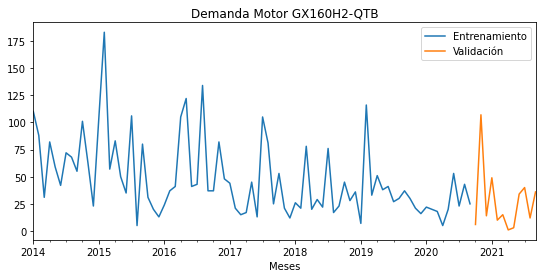

In [67]:
# Separación datos train-test
# ==============================================================================
steps = 12
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='Entrenamiento')
datos_test.plot(ax=ax, label='Validación')
ax.set_title('Demanda Motor GX160H2-QTB')
ax.legend();

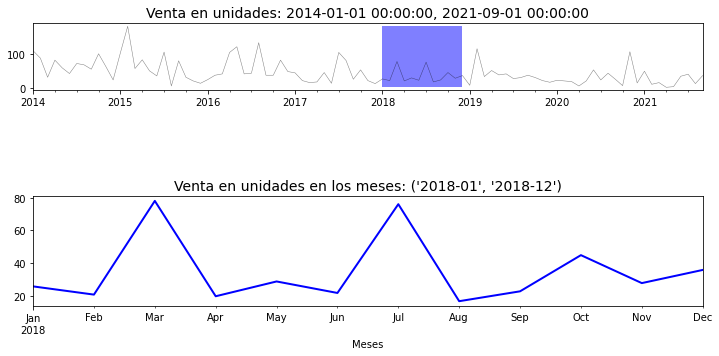

In [68]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2018-01','2018-12')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.8, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.Ventas.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Ventas)
max_y = max(data.Ventas)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

data[zoom[0]: zoom[1]].Ventas.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Venta en unidades: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Venta en unidades en los meses: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [69]:
data['Año']= data.index.year
data['Mes']= data.index.month
data

,Ventas,Año,Mes
Meses,,,
2014-01-01,110,2014,1
2014-02-01,88,2014,2
2014-03-01,31,2014,3
2014-04-01,82,2014,4
2014-05-01,59,2014,5
...,...,...,...
2021-05-01,3,2021,5
2021-06-01,34,2021,6
2021-07-01,40,2021,7


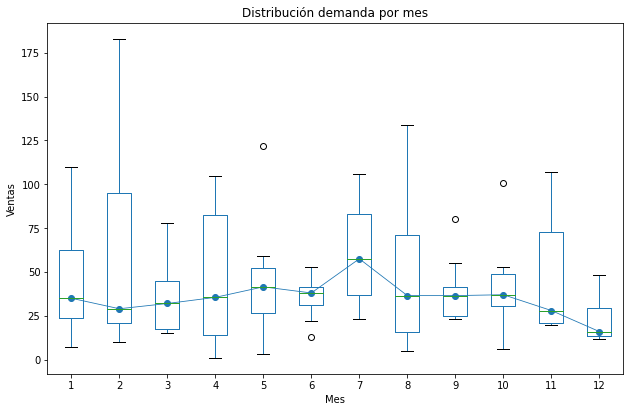

In [70]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6.5))
data.boxplot(column='Ventas', by='Mes', ax=ax,)
data.groupby('Mes')['Ventas'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Ventas')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

#Gráficos de autocorrelación

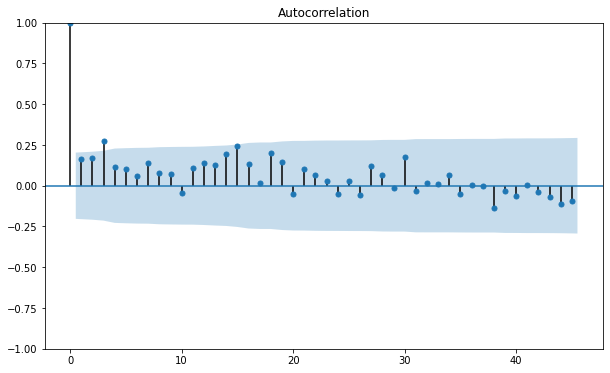

In [71]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data.Ventas, ax=ax, lags=45)
plt.show()

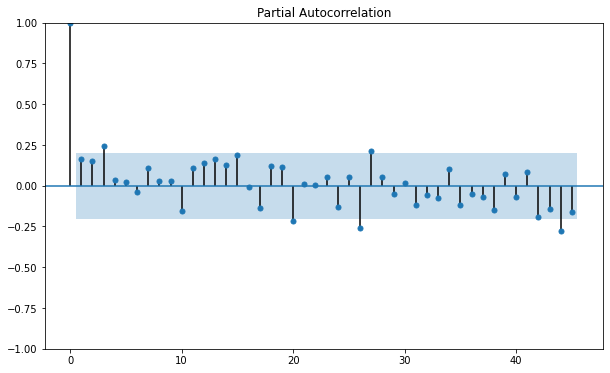

In [72]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(data.Ventas, ax=ax, lags=45)
plt.show()

Normalización de los datos, para centralizarlos y generalizar el problema a realizar, es una práctica necesaria a nivel estadístico para garantizar que se están analizando los conjuntos de datos en un rango que permita a los modelos ser mucho más específicos y precisos

In [73]:
datos_train = (datos_train - datos_train.min())/(datos_train.max() - datos_train.min())
print(datos_train)

Meses
2014-01-01    0.589888
2014-02-01    0.466292
2014-03-01    0.146067
2014-04-01    0.432584
2014-05-01    0.303371
                ...   
2020-05-01    0.084270
2020-06-01    0.269663
2020-07-01    0.101124
2020-08-01    0.213483
2020-09-01    0.112360
Freq: MS, Name: y, Length: 81, dtype: float64


In [74]:
datos_test = (datos_test - datos_test.min())/(datos_test.max() - datos_test.min())
print(datos_test)

Meses
2020-10-01    0.047170
2020-11-01    1.000000
2020-12-01    0.122642
2021-01-01    0.452830
2021-02-01    0.084906
2021-03-01    0.132075
2021-04-01    0.000000
2021-05-01    0.018868
2021-06-01    0.311321
2021-07-01    0.367925
2021-08-01    0.103774
2021-09-01    0.330189
Freq: MS, Name: y, dtype: float64


#ForecasterAutoreg

Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [75]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(),
                    lags=7
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor()
Lags: [1 2 3 4 5 6 7]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

#Predicciones

Una vez entrenado el modelo, se predicen los datos de validación (12 meses a futuro).

In [80]:
# Predicciones
# ==============================================================================
steps = 81
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_train.index)
predicciones.head()

Meses
2014-01-01    0.183539
2014-02-01    0.197079
2014-03-01    0.211348
2014-04-01    0.206966
2014-05-01    0.183764
Freq: MS, dtype: float64

In [81]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_train,
                y_pred = predicciones
            )
print(f"Error de train (mse): {error_mse}")

Error de train (mse): 0.04949112968963577


In [84]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

Meses
2020-10-01    0.183539
2020-11-01    0.197079
2020-12-01    0.211348
2021-01-01    0.206966
2021-02-01    0.183764
Freq: MS, dtype: float64

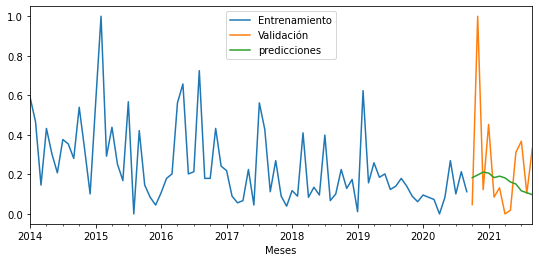

In [85]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='Entrenamiento')
datos_test.plot(ax=ax, label='Validación')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

#Error de las predicciones en el conjunto de test
Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse)

In [86]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07843354347753019


#Ajuste de hiperparámetros
El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Para identificar la mejor combinación de lags e hiperparámetros, la librería Skforecast dispone de las estrategias de validación cruzada y backtesting. Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting. En este caso, se utiliza time series cross-validation en el conjunto de datos de entrenamiento. Para el primer fold, el 50% inicial de las observaciones son los datos de entrenamiento y los siguientes 10 steps respresentan el set de validación. En los folds sucesivos, el conjunto de entrenamiento contendrá todos los datos utilizados en el fold anterior y los siguientes 10 steps se utilizarán como nuevos datos de validación. Este proceso se repetirá hasta utilizar todo el conjunto de datos de entrenamiento

In [87]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(),
                    lags      = 10 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 7]}

# Lags utilizados como predictores
lags_grid = [5, 12]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-12-07 00:26:54,534 root       INFO  Number of models compared: 12
loop lags_grid: 100%|██████████| 2/2 [00:32<00:00, 16.20s/it]
2021-12-07 00:27:26,958 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
params: {'max_depth': 5, 'n_estimators': 500}



In [88]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",0.027190,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 500}",0.027915,7,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.027915,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",0.028492,3,100
1,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 500}",0.028697,3,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 500}",0.028830,3,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 7, 'n_estimators': 100}",0.029626,7,100
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",0.030164,3,100
5,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 500}",0.033675,7,500
3,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 500}",0.033832,5,500


In [91]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=500)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      =12
                )

forecaster_rf.fit(y=datos_train)

In [92]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

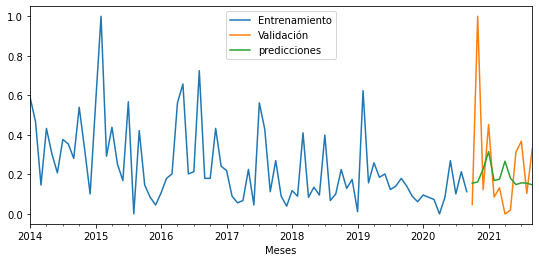

In [93]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='Entrenamiento')
datos_test.plot(ax=ax, label='Validación')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [94]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.079884838613484


In [42]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster_rf.get_feature_importances()
dict(zip(forecaster_rf.lags, impotancia))

{1: 0.08835220010445823,
 2: 0.10849381485809281,
 3: 0.16418105235278196,
 4: 0.09534734690930545,
 5: 0.052457577983045255,
 6: 0.026210612476797814,
 7: 0.040038244597536625,
 8: 0.08008871360114575,
 9: 0.0666549546151569,
 10: 0.10142575752002578,
 11: 0.06089039081702857,
 12: 0.11585933416462489}

#Forecasting autorregresivo recursivo con predictores custom

In [43]:
data = pd.read_csv('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/GX160H2-QTB.csv')
data.head()

,Meses,Ventas
0,2014-1,110
1,2014-2,88
2,2014-3,31
3,2014-4,82
4,2014-5,59


In [95]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# --- Donde parse_dates indica qué columna de los datos se selecciona como información de fecha y hora,
# --- index_col le dice a los pandas qué columna usar como índice
# --- date_parser usa una función (este artículo usa una expresión lambda en su lugar) para convertir una cadena en una variable de fecha y hora

datos = pd.read_csv('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/GX160H2-QTB.csv', parse_dates=['Meses'], index_col='Meses',date_parser=dateparse)
datos.head()
datos.index
datos = datos.rename(columns={'Ventas': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

In [96]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Normalizamos los datos

In [97]:
datos_train = (datos_train - datos_train.min())/(datos_train.max() - datos_train.min())
print(datos_train)

Meses
2014-01-01    0.589888
2014-02-01    0.466292
2014-03-01    0.146067
2014-04-01    0.432584
2014-05-01    0.303371
2014-06-01    0.207865
2014-07-01    0.376404
2014-08-01    0.353933
2014-09-01    0.280899
2014-10-01    0.539326
2014-11-01    0.325843
2014-12-01    0.101124
2015-01-01    0.556180
2015-02-01    1.000000
2015-03-01    0.292135
2015-04-01    0.438202
2015-05-01    0.252809
2015-06-01    0.168539
2015-07-01    0.567416
2015-08-01    0.000000
2015-09-01    0.421348
2015-10-01    0.146067
2015-11-01    0.084270
2015-12-01    0.044944
2016-01-01    0.106742
2016-02-01    0.179775
2016-03-01    0.202247
2016-04-01    0.561798
2016-05-01    0.657303
2016-06-01    0.202247
2016-07-01    0.213483
2016-08-01    0.724719
2016-09-01    0.179775
2016-10-01    0.179775
2016-11-01    0.432584
2016-12-01    0.241573
2017-01-01    0.219101
2017-02-01    0.089888
2017-03-01    0.056180
2017-04-01    0.067416
2017-05-01    0.224719
2017-06-01    0.044944
2017-07-01    0.561798
2017-

In [98]:
datos_test = (datos_test - datos_test.min())/(datos_test.max() - datos_test.min())
print(datos_test)

Meses
2018-10-01    0.382609
2018-11-01    0.234783
2018-12-01    0.304348
2019-01-01    0.052174
2019-02-01    1.000000
2019-03-01    0.278261
2019-04-01    0.434783
2019-05-01    0.321739
2019-06-01    0.347826
2019-07-01    0.226087
2019-08-01    0.252174
2019-09-01    0.313043
2019-10-01    0.252174
2019-11-01    0.173913
2019-12-01    0.130435
2020-01-01    0.182609
2020-02-01    0.165217
2020-03-01    0.147826
2020-04-01    0.034783
2020-05-01    0.165217
2020-06-01    0.452174
2020-07-01    0.191304
2020-08-01    0.365217
2020-09-01    0.208696
2020-10-01    0.043478
2020-11-01    0.921739
2020-12-01    0.113043
2021-01-01    0.417391
2021-02-01    0.078261
2021-03-01    0.121739
2021-04-01    0.000000
2021-05-01    0.017391
2021-06-01    0.286957
2021-07-01    0.339130
2021-08-01    0.095652
2021-09-01    0.304348
Freq: MS, Name: y, dtype: float64


In [99]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
def create_predictors(y):
    '''
    Crear los primeros 10 lags.
    Calcular la media móvil de los últimos 12 valores.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(12).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train 

In [100]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(),
                    fun_predictors = create_predictors,
                    window_size    = 12
                )

forecaster_rf.fit(y=datos_train)
forecaster_rf

=======================ForecasterAutoregCustom=======================
Regressor: RandomForestRegressor()
Predictors created with: create_predictors
Window size: 12
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [101]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

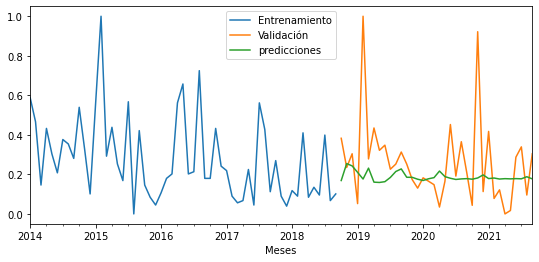

In [102]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='Entrenamiento')
datos_test.plot(ax=ax, label='Validación')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [103]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.05045436653487929


In [53]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(),
                    fun_predictors = create_predictors,
                    window_size    = 12
                )



In [54]:
# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 1500],
              'max_depth': [3, 5, 10]}



In [55]:
resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

2021-12-07 00:03:25,259 root       INFO  Number of models compared: 6
loop lags_grid: 100%|██████████| 1/1 [00:35<00:00, 35.65s/it]
2021-12-07 00:04:00,930 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 3, 'n_estimators': 100}



In [56]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.050225,3,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 1500}",0.051984,10,1500
1,custom predictors,"{'max_depth': 3, 'n_estimators': 1500}",0.052193,3,1500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 1500}",0.052342,5,1500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.058667,5,100
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.058911,10,100


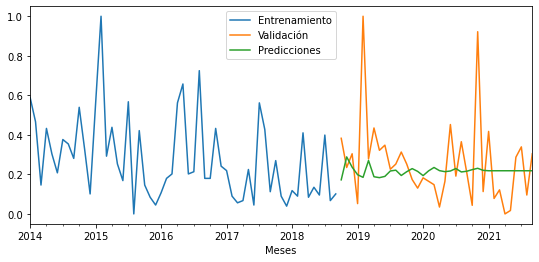

In [57]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='Entrenamiento')
datos_test.plot(ax=ax, label='Validación')
predicciones.plot(ax=ax, label='Predicciones')
ax.legend();

In [58]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test, y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.04766248014719154
